In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import stack
from keras import Sequential, Model, models
from tensorflow.keras.layers import Concatenate, Input, Bidirectional, LSTM, LSTMCell, Dense, Lambda, RepeatVector, Dot, Softmax, Reshape, Concatenate
from tensorflow.keras.activations import tanh, relu, softmax

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
############# Hiperparâmetros #############
input_sequence_lenght = 30
input_vocab_size = 37
encoder_hidden_size = 32
output_vocab_size = 11
output_sequence_lenght = 10
attention_size = 10

In [ ]:
############# Declaração das redes #############
# Encoder:
encoder_inputs = Input(shape=(input_sequence_lenght, input_vocab_size))
encoder_lstm = Bidirectional(LSTM(encoder_hidden_size, return_sequences=True, return_state=True))
# Attention:
attention_W = Dense(attention_size, activation=tanh, use_bias=False)
attention_V = Dense(1, activation=relu, use_bias=False)
# Decoder:
decoder_lstm = LSTMCell(encoder_hidden_size * 2)
decoder_dense = Dense(output_vocab_size, activation=softmax, use_bias=False)


############# Declaração das conexões entre as redes #############
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(encoder_inputs)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
lstm_states = [state_h, state_c]
decoder_outputs = []
attention_wheights_list = []
for i in range(output_sequence_lenght):
    # Mecanismo de Atenção
    attention_input = Concatenate()([RepeatVector(input_sequence_lenght)(lstm_states[0]), encoder_outputs])
    attention_temp = attention_V(attention_W(attention_input))
    attention_weights = Reshape((input_sequence_lenght,))(attention_temp)
    attention_wheights = Softmax()(attention_weights)
    attention_wheights_list.append(attention_weights)
    context_vector = Dot(axes=1)([attention_wheights, encoder_outputs])

    # Célula LSTM
    lstm_output, lstm_states = decoder_lstm(context_vector, states=lstm_states)

    # Dense com softmax
    decoder_outputs.append(decoder_dense(lstm_output))
model_output = Lambda(lambda x: stack(x, axis=1))(decoder_outputs)
attention_output = Lambda(lambda x: stack(x, axis=1))(attention_wheights_list)

############# Declaração do modelo #############
model = Model(encoder_inputs, model_output)
attention_model = Model(encoder_inputs, attention_output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
############# Import de auxiliares #############
# São funções para formatação em vetores one-hot e para download do dataset

import os
if not os.path.exists("auxfunctions.py"):
  !wget https://raw.githubusercontent.com/LipeAma/Phrase2Date/refs/heads/main/auxfunctions.py
from auxfunctions import phrase2hotvec, date2hotvec, hotvec2phrase, hotvec2date, dataset

dataset[:10] # Exemplo do dataset

[['9 may 1998', '1998-05-09'],
 ['10.11.19', '2019-11-10'],
 ['9/10/70', '1970-09-10'],
 ['saturday april 28 1990', '1990-04-28'],
 ['thursday january 26 1995', '1995-01-26'],
 ['monday march 7 1983', '1983-03-07'],
 ['sunday may 22 1988', '1988-05-22'],
 ['08 jul 2008', '2008-07-08'],
 ['8 sep 1999', '1999-09-08'],
 ['thursday january 1 1981', '1981-01-01']]

In [ ]:
def predict(src):
  src = phrase2hotvec(src, input_sequence_lenght)
  pred = model.predict(np.array([src]))[0]
  pred = hotvec2date(pred)
  return ''.join(pred)

In [ ]:
def attention_map(src):
    f = plt.figure(figsize=(25, 25))
    ax = f.add_subplot(1, 1, 1)
    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')

    src = phrase2hotvec(src, input_sequence_lenght)

    ax.set_xticks(range(input_sequence_lenght))
    ax.set_xticklabels(hotvec2phrase(src))

    src = np.array([src])
    attention_map = attention_model.predict(src)[0]
    pred = model.predict(src)[0]
    pred = hotvec2date(pred)

    i = ax.imshow(attention_map, interpolation='nearest', cmap='Blues')

    #cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
    #cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
    #cbar.ax.set_xlabel('Alpha value (Probability output of the "softmax")', labelpad=2)

    ax.set_yticks(range(output_sequence_lenght))
    ax.set_yticklabels(pred)
    f.show()

In [ ]:
############# Organização do dataset #############
source, target = list(zip(*[(phrase2hotvec(phrase, input_sequence_lenght), date2hotvec(date))  for (phrase, date) in dataset]))
source = np.array(source)
target = np.array(target)
print("Sources shape:", source.shape)
print("Source example:\n", source[0])
print("\nTargets shape:", target.shape)
print("Target example:\n", target[0])

Sources shape: (10000, 30, 37)
Source example:
 [[0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]

Targets shape: (10000, 10, 11)
Target example:
 [[0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1]]


In [ ]:
from math import ceil
dataset_size = len(dataset)
training_ratio = 0.75
training_size = ceil(dataset_size * training_ratio)
X_train = source[:training_size]
y_train = target[:training_size]
X_test = source[training_size:]
y_test = target[training_size:]

In [ ]:
############# Treinamento 10 épocas #############
history = model.fit(X_train, y_train, epochs=10, batch_size=75)
history = model.fit(X_train, y_train, epochs=40, batch_size=750)
history = model.fit(X_train, y_train, epochs=100, batch_size=7500)

In [ ]:
history = model.fit(X_train, y_train, epochs=1000, batch_size=7500)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.9994 - loss: 0.0098


In [ ]:
############# Verificando Acurácia #############
total_correct_chars = 0
total_correct_dates = 0
results = model.predict(source[:training_size])
for i in range(training_size, dataset_size):
  src = source[i]
  trg = dataset[i-training_size][1]
  pred = results[i-training_size]
  pred = hotvec2date(pred)

  correct_chars = sum([c1 == c2 for (c1,c2) in zip (pred, trg)])
  total_correct_chars += correct_chars
  if correct_chars == 10: total_correct_dates += 1

dates_percentage = total_correct_dates / (dataset_size - training_size) * 100
chars_percentage = total_correct_chars / ((dataset_size - training_size)*10) * 100
print(f"Correct dates: {dates_percentage:.1f}%")
print(f"Correct chars: {chars_percentage:.1f}%")


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Correct dates: 99.3%
Correct chars: 99.9%


In [ ]:
predict("23 feb 2005")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


'2005-02-23'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


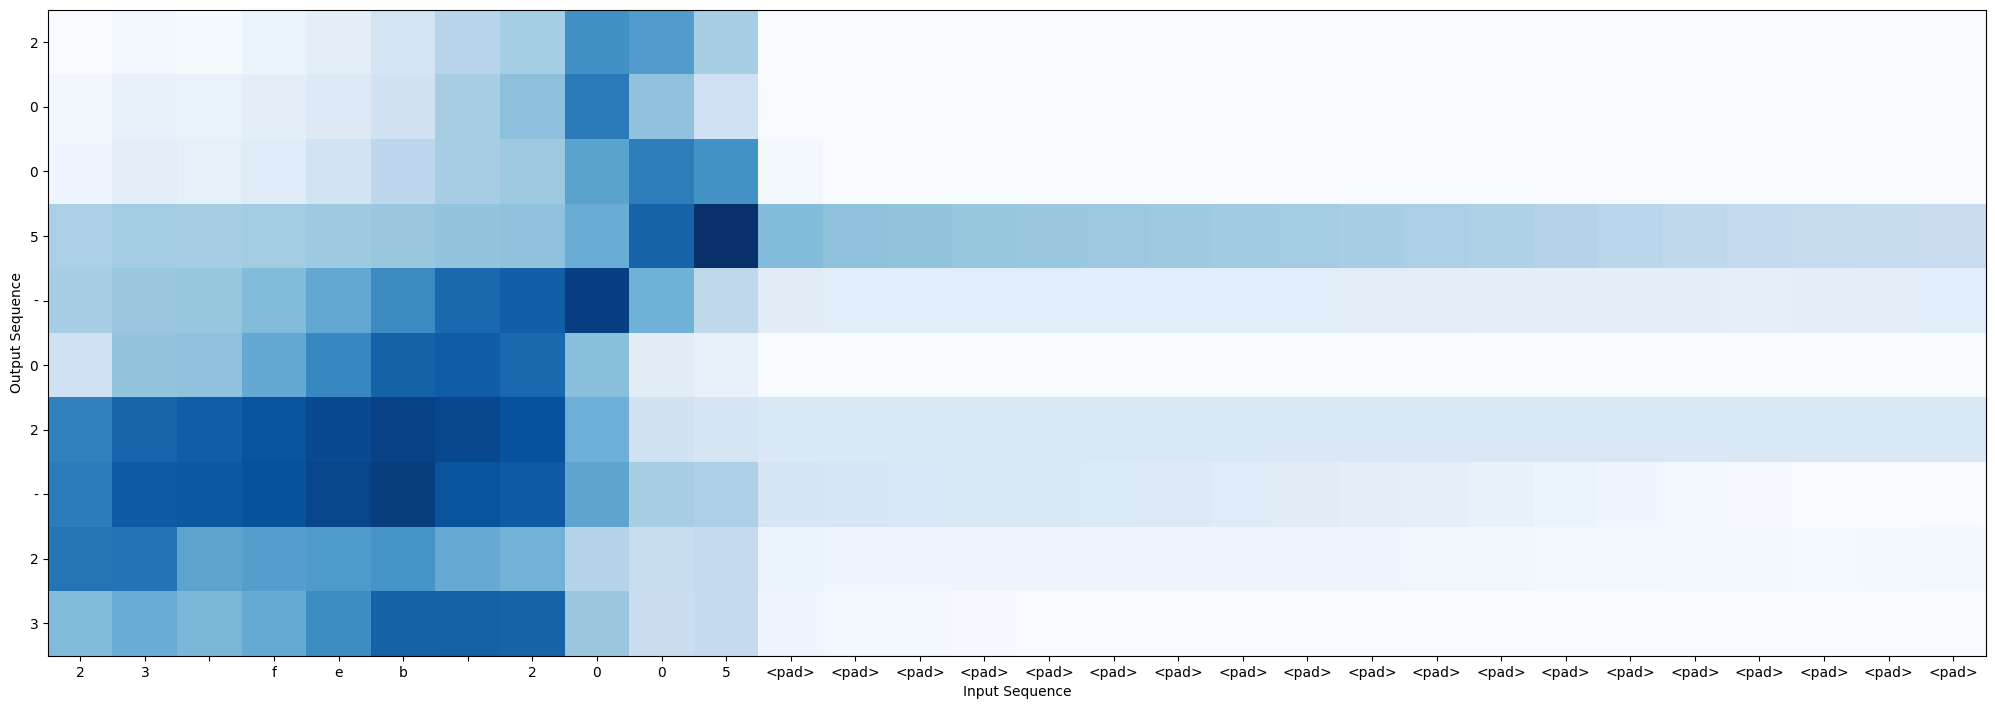

In [ ]:
attention_map("23 feb 2005")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


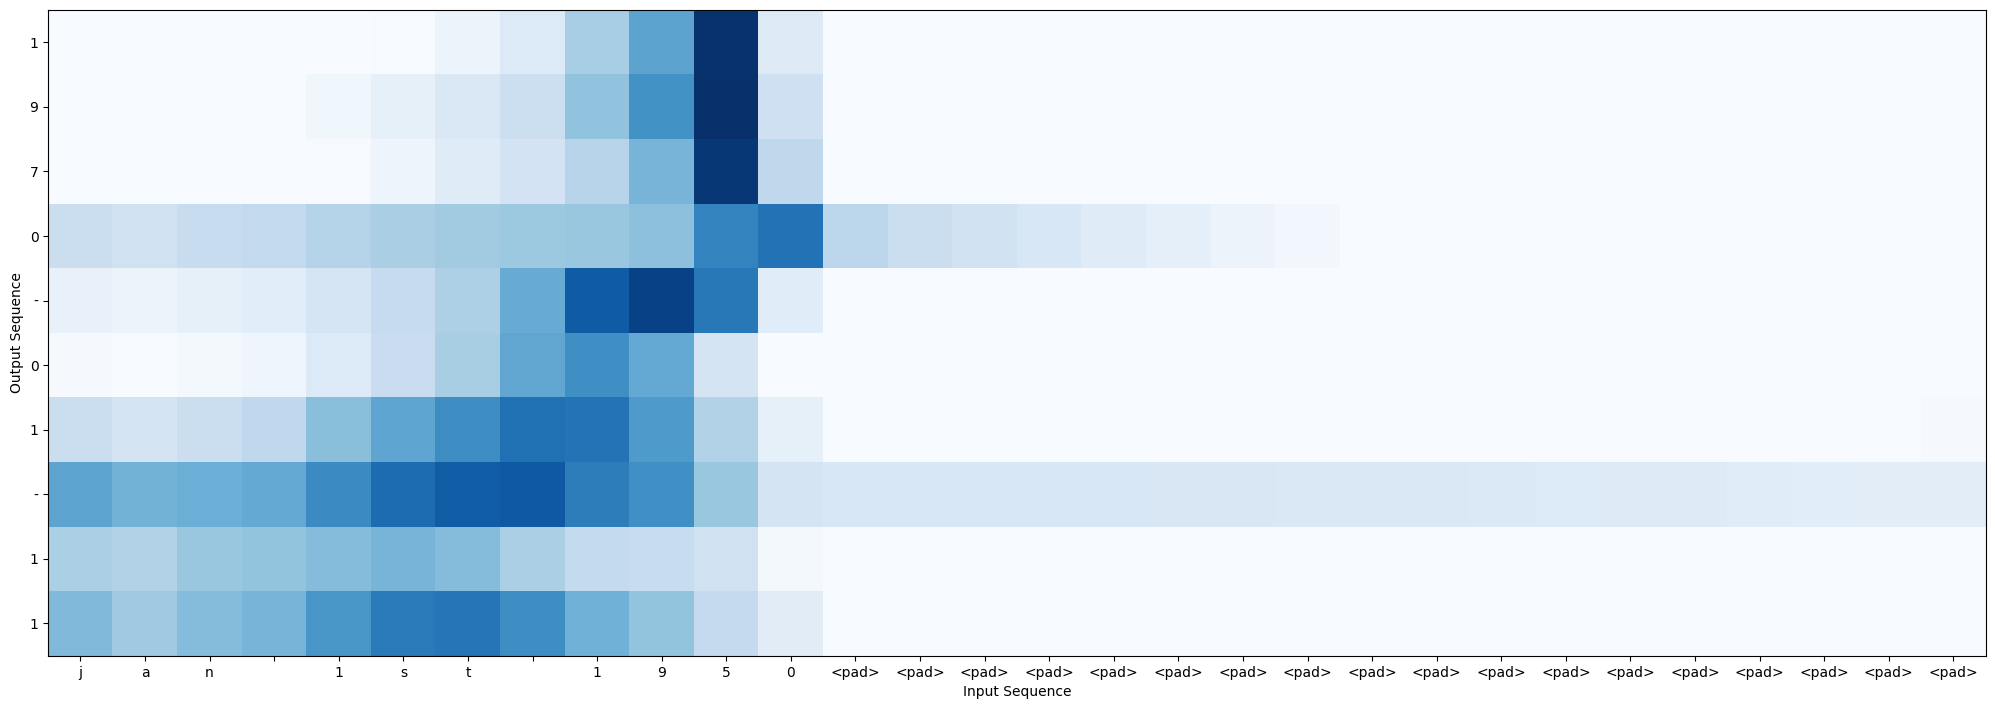

In [ ]:
attention_map("jan 1st 1950")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


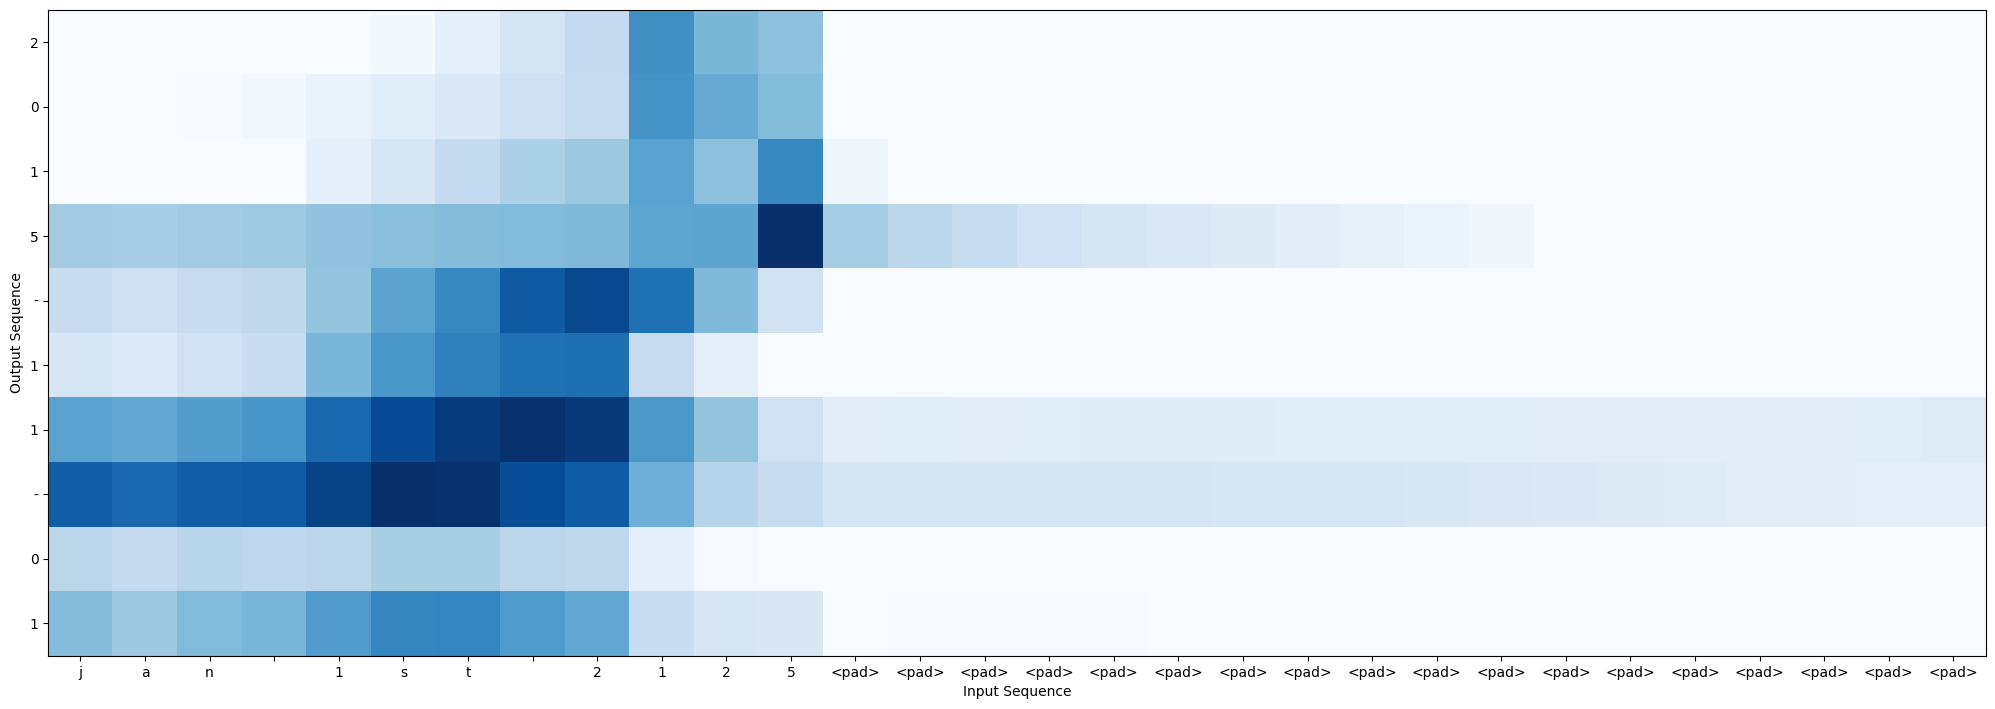

In [ ]:
attention_map("jan 1st 2125")